In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib
from sklearn.model_selection import train_test_split


In [2]:
X = pd.read_csv("energy_efficiency_data.csv")

ort = pd.get_dummies(X['Orientation'], prefix='Orientation', drop_first=False)
X = pd.concat([X,ort], axis=1)
gad = pd.get_dummies(X['Glazing Area Distribution'], prefix='Glazing Area Distribution', drop_first=True)

X = pd.concat([X, gad], axis=1)
drop_features = ['Orientation', 'Glazing Area Distribution','Cooling Load',]
X = X.drop(drop_features, axis=1)


In [3]:
cor_mat =X.corr()
cor_mat.style.background_gradient().set_precision(2)


,# Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Glazing Area,Heating Load,Orientation_2.0,Orientation_3.0,Orientation_4.0,Orientation_5.0,Glazing Area Distribution_1.0,Glazing Area Distribution_2.0,Glazing Area Distribution_3.0,Glazing Area Distribution_4.0,Glazing Area Distribution_5.0
# Relative Compactness,1,-0.99,-0.2,-0.87,0.83,-3.2e-18,0.62,-1.7e-17,-1.7e-17,-2.9e-17,-2.6e-17,4.9e-17,5e-17,4.9e-17,5e-17,5.3e-17
Surface Area,-0.99,1,0.2,0.88,-0.86,3.6e-17,-0.66,4e-16,2.4e-16,4.6e-16,1e-16,-4.1e-17,-4.3e-17,-4.5e-17,-4.7e-17,-4.1e-17
Wall Area,-0.2,0.2,1,-0.29,0.28,1e-17,0.46,0,0,0,0,0,0,0,0,0
Roof Area,-0.87,0.88,-0.29,1,-0.97,5.6e-17,-0.86,2.2e-16,-2.5e-16,1.1e-16,-1e-16,2e-16,2e-16,2e-16,1.9e-16,1.9e-16
Overall Height,0.83,-0.86,0.28,-0.97,1,-2.5e-18,0.89,0,0,0,0,0,0,0,0,0
Glazing Area,-3.2e-18,3.6e-17,1e-17,5.6e-17,-2.5e-18,1,0.27,3e-17,-2.3e-16,1.6e-17,-6.2e-17,0.056,0.056,0.056,0.056,0.056
Heating Load,0.62,-0.66,0.46,-0.86,0.89,0.27,1,0.00032,0.0042,-0.0027,-0.0018,0.034,0.03,0.018,0.028,0.018
Orientation_2.0,-1.7e-17,4e-16,0,2.2e-16,0,3e-17,0.00032,1,-0.33,-0.33,-0.33,0,0,0,0,0
Orientation_3.0,-1.7e-17,2.4e-16,0,-2.5e-16,0,-2.3e-16,0.0042,-0.33,1,-0.33,-0.33,0,0,0,0,0
Orientation_4.0,-2.9e-17,4.6e-16,0,1.1e-16,0,1.6e-17,-0.0027,-0.33,-0.33,1,-0.33,0,0,0,0,0


In [4]:
Y = ['Heating Load']
X, Y = X.drop(Y, axis=1), X[Y]

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=42)

X_train = np.array(X_train)
Y_train =np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(576, 15) (576, 1)
(192, 15) (192, 1)


In [6]:
class neural_network():
    def __init__(self,structure,input_dimention,lamda=0.001):
        self.structure = structure
        self.weight = []
        self.erms = []
        self.final = []

        for i in range(0,len(structure)):
            if i==0:
                self.weight.append(np.random.rand(structure[i],input_dimention+1)*lamda)
            else:
                self.weight.append(np.random.rand(structure[i],structure[i-1]+1)*lamda)
                
    def train(self,features,target,epoch,learning_rate,batch_size,lamb):
        for iter in range(0,epoch):
            output = []
            num = np.arange(len(features))
            batch_data = 0
            temp_dweight = []
            for index in range(0,len(features)):
                X = np.c_[np.mat(features[num[index]]),1]
                Activation = []
                d_weight = []
               
                for layer in range(0,len(self.structure)):
                    w = [self.weight[layer][node] for node in range(0,self.structure[layer])]
                    Weight = np.mat(w)
                    if layer==0:
                        temp = []
                        for node in range(0,self.structure[layer]):
                            x = X * np.transpose(Weight[node])
                            temp.append(x[0,0])
                        Activation.append(temp)
                    else:
                             temp = []
                             activ = np.mat(Activation[layer-1])
                             activ = np.c_[activ,1]
                             for node in range(0,self.structure[layer]):
                                      x = activ * np.transpose(Weight[node])
                                      temp.append(x[0,0])
                             Activation.append(temp)
                output.append(Activation)
                    				
                error = output[index][len(self.structure)-1] - target[num[index]]
                d_weight = []
                d_activation = []
                for layer in range(0,len(self.structure)):
                    d_J = []
                    dJ_d_activ = []
                    _layer = len(self.structure) - 1 - layer
                    w = [self.weight[_layer][node] for node in range(0,self.structure[_layer])]
                    if layer == 0:
                        w = w[0][0:(len(w[0])-1)]
                        err = output[index][_layer-1]
                        err.append(1)
                        d_J.append(error * np.array(err))
                        d_weight.append(d_J)
                        d_activation.append(error * np.array(w))
                    else:
                        if layer != (len(self.structure)-1):
                            err = output[index][_layer-1]
                            err.append(1)
                            [d_J.append(d_activation[layer-1][node] * np.array(err)) for node in range(0,self.structure[_layer])]
                            d_weight.append(d_J)
                            [dJ_d_activ.append(d_activation[layer-1][node] * np.array(w[node][0:(len(w[node])-1)])) for node in range(0,self.structure[_layer])]
                            for node in range(0,len(dJ_d_activ)):
                                if node!=0:
                                    dJ_d_activ[0] = np.array(dJ_d_activ[0]) + np.array(dJ_d_activ[node])
                            d_activation.append(dJ_d_activ[0])
                        else:
                            err = np.append(np.array(features[index]),1)
                            [d_J.append(d_activation[layer-1][node] * np.array(err)) for node in range(0,self.structure[_layer])]
                            d_weight.append(d_J)
                temp_dweight.append(d_weight)
                if np.round(iter/batch_size)==iter/batch_size or iter!=0:
                    if iter != (epoch-1):
                        for layer in range(0,len(self.structure)):
                            for node in range(0,self.structure[layer]):
                                self.weight[layer][node] = self.weight[layer][node] - (learning_rate * temp_dweight[0][len(self.structure)-1-layer][node])
                        batch_data = 0
                        temp_dweight = []
                else:
                    if batch_data!=0:
                        for layer in range(0,len(self.structure)):
                            for node in range(0,self.structure[layer]):
                                temp_dweight[0][layer][node] = temp_dweight[batch_data][layer][node] + temp_dweight[0][layer][node]
                    batch_data = batch_data + 1
                if iter==(epoch-1):
                    self.final.append(output[index][len(self.structure)-1])
            output = np.array(output)
            SSE = np.sum([(target[id] - output[id,len(self.structure)-1])**2 for id in range(0,len(features))])
            #print(iter,np.sqrt(SSE/len(features)))
            self.erms.append(np.sqrt(SSE/len(features)))
        #print(self.weight[0])
#%% 
    def test(self,features_test,target):
        MSE = 0
        Erms = []
        output = []
        final = []
        for index in range(0,len(features_test)):
            X = np.c_[np.mat(features_test[index]),1]
            Activation = []
            for layer in range(0,len(self.structure)):
                w = [self.weight[layer][node] for node in range(0,self.structure[layer])]
                Weight= np.mat(w)
                if layer==0:
                    temp = []
                    for node in range(0,self.structure[layer]):
                        x = X * np.transpose(Weight[node])
                        temp.append(x[0,0])
                    Activation.append(temp)
                else:
                    temp = []
                    activ = np.mat(Activation[layer-1])
                    activ = np.c_[activ,1]
                    for node in range(0,self.structure[layer]):
                        x = activ * np.transpose(Weight[node])
                        temp.append(x[0,0])
                    Activation.append(temp)
            output.append(Activation)
            MSE = MSE + ((output[index][len(self.structure)-1] - target[index])**2)
            final.append(output[index][len(self.structure)-1])
        Erms = np.sqrt(MSE/len(features_test))
        return Erms,final

In [9]:
#epoch,learning_rate,batch_size,lamb        
Lr = 0.00001
epoch = 500
batch_size = 16
NN = neural_network([10,10,1],X_train.shape[1])
NN.train(X_train,Y_train,epoch,Lr,batch_size,0)
#%%



Train ERMS 7.732806837144857
Test ERMS [6.26782023]
learning rate 1e-05
input dimention 15
batch size 16


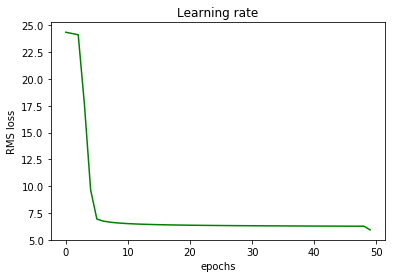

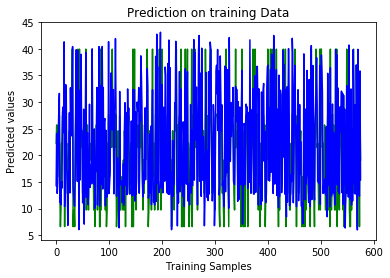

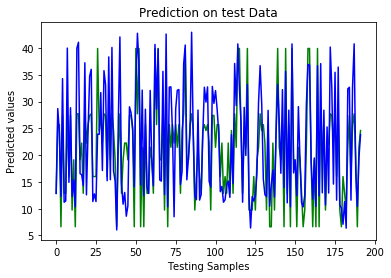

In [12]:
print("Train ERMS",np.mean(NN.erms))
#%%
erms,out = NN.test(X_test,Y_test)
print("Test ERMS",erms)
print("learning rate",Lr)
print("input dimention",X_train.shape[1])
print("batch size",batch_size)
plt.figure(1), plt.plot(NN.erms, 'g')
plt.xlabel("epochs")
plt.ylabel("RMS loss")
plt.title("Learning rate")
plt.savefig("learning_curve.jpeg")
plt.figure(2), plt.plot(NN.final,'g'), plt.plot(Y_train,'b')
plt.xlabel("Training Samples")
plt.ylabel("Predicted values")
plt.title("Prediction on training Data")
plt.savefig("pred_train.jpeg")
plt.figure(3), plt.plot(out,'g'), plt.plot(Y_test,'b')
plt.xlabel("Testing Samples")
plt.ylabel("Predicted values")
plt.title("Prediction on test Data")
plt.savefig("pred_test.jpeg")
plt.show()